<a href="https://colab.research.google.com/github/adventurecricket/detecting-dogs-and-cats-with-CNN-from-scratch-Step-by-step/blob/main/Detecting_dogs_and_cats_with_CNN_from_scratch_Step_by_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importing Libraries**

In [ ]:
import os
import shutil
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import pandas as pd
from PIL import Image 

import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline

# **2. Load and Extract data**

From Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

If you unzipped the files in the wrong place, you can use the cell below to remove them.

In [ ]:
# files = os.listdir("/content/drive/MyDrive")
# for fi in files:
#   if "cat" in fi or "dog" in fi:
#     try:
#       os.remove("/content/drive/MyDrive/" + fi)
#     except ValueError:
#       print("Error: "+ ValueError)

In [ ]:
INPUT_ZIP_DIR_PATH = "/content/drive/MyDrive/Colab Notebooks/data/dogs-vs-cats" # path of zip data.
INPUT_DIR_PATH = "/content/data/input/dogs-vs-cats" # path of the unzip data.

zip_files = ['train', 'test1']

if os.path.exists(INPUT_DIR_PATH):
      shutil.rmtree(INPUT_DIR_PATH)

for zip_file in zip_files:
  with zipfile.ZipFile("{}/{}.zip".format(INPUT_ZIP_DIR_PATH, zip_file), mode="r") as zf:
    # Use for Tensor
    # if zip_file == "test1":
    #   zf.extractall("{}/test/".format(INPUT_DIR_PATH))
    # else:
    #   zf.extractall("{}/".format(INPUT_DIR_PATH))
    
    # Manual
    zf.extractall("{}/".format(INPUT_DIR_PATH))

    print("{} unziped.".format(zip_file))

Check the data size after unzipping

In [ ]:
train_files = os.listdir("{}/{}".format(INPUT_DIR_PATH, zip_files[0]))
# Use for Tensor
#test_files = os.listdir("{}/test/{}".format(INPUT_DIR_PATH, zip_files[1]))
test_files = os.listdir("{}/{}".format(INPUT_DIR_PATH, zip_files[1]))

print("There are {} training files".format(len(train_files)))
print("There are {} testing files".format(len(test_files)))

### **2.1 Analyze data**

**Quick view**

We just do it on the training set and leave the testing set aside. Test kit for testing only

In [ ]:
# A quick view on the training set
def to_dataframe(lst_file):
    files, labels = [], []

    for file in lst_file:
      files.append(file)
      labels.append(file[:3])

    df = pd.DataFrame({"filename": files, "label": labels})

    return df

In [ ]:
df = to_dataframe(train_files)
df.head()

How many cats and dogs are in the training set?

In [ ]:
print(df['label'].value_counts())

plt.figure(figsize=(6, 6))
sns.countplot(x = df['label'])
plt.show()

In [ ]:
# cats = df.loc[df['label'] == 'cat']
# dogs = df.loc[df['label'] == 'dog']
cats = [file for file in train_files if file[:3] == 'cat']
dogs = [file for file in train_files if file[:3] == 'dog']

Show some images

In [ ]:
plt.figure(figsize=(15,7))

for i, c in enumerate(np.random.randint(0,len(cats),5), start=1):
  im = img.imread("{}/{}/{}".format(INPUT_DIR_PATH, zip_files[0], cats[c]))
  plt.subplot(2,5,i)
  plt.imshow(im)

for i, c in enumerate(np.random.randint(0,len(dogs),5), start=6):
  im = img.imread("{}/{}/{}".format(INPUT_DIR_PATH, zip_files[0], dogs[c]))
  plt.subplot(2,5,i)
  plt.imshow(im)

Looking at a few random photos in the directory, we can see that the photos are color and have different shapes and sizes.

### **2.2 Split training data and resize photo's size.**

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

We will choose a size of 128x128 pixels for each image. 

In [ ]:
IMG_HEIGHT = 128
IMG_WEIGHT = 128
IMG_SIZE = (IMG_HEIGHT, IMG_WEIGHT)

##### Use for manual

Resize and convert images to numpy array

In [ ]:
def trans_img(files, dir, img_size):
  lst_images = []
  for fil in files:
    img_org = Image.open("{}/{}".format(dir, fil))
    new_img = img_org.resize(img_size)
    lst_images.append(np.asarray(new_img))

  return np.array(lst_images)

In [ ]:
train_dir = "{}/{}/".format(INPUT_DIR_PATH, zip_files[0])
train_numpy = trans_img(train_files, train_dir, IMG_SIZE)

In [ ]:
test_dir = "{}/{}/".format(INPUT_DIR_PATH, zip_files[1])
test_numpy = trans_img(test_files, test_dir, IMG_SIZE)

In [ ]:
print("Train shape: ", train_numpy.shape)
print("Test shape: ", test_numpy.shape)

Display some images after resizing

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(2,5,1)
plt.imshow(train_numpy[50])

plt.subplot(2,5,2)
plt.imshow(test_numpy[50])

As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.
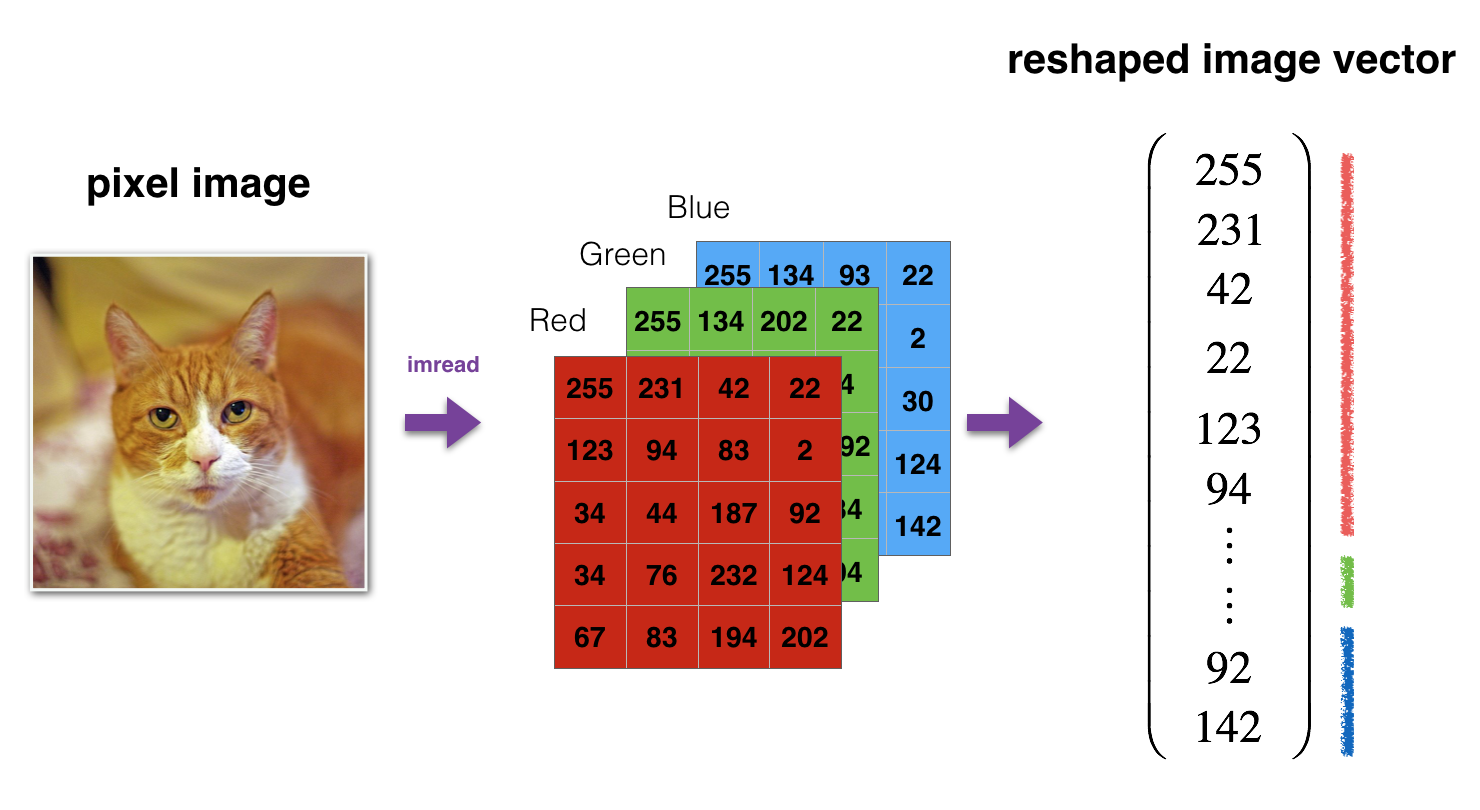

In [ ]:
# Reshape the training and test set.
train_x_flatten = train_numpy.reshape(train_numpy.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_numpy.reshape(test_numpy.shape[0], -1).T      # The "-1" makes reshape flatten the remaining dimensions

# Standardize data to have feature values between 0 and 1.
# train_x_flatten = train_x_flatten/255.
# test_x_flatten = test_x_flatten/255.

print("train_x_flatten' shape: ", train_x_flatten.shape)
print("test_x_flatten' shape: ", test_x_flatten.shape)

Note:  49152  =  128x128x3 , which is the size of one reshaped image vector.

##### Use for Tensor model


The `image_dataset_from_directory` API requires subfolders for each of the classes within the directory. This way it can automatically identify and assign class labels to images.

The directory structure as follows:
```
dataset_dogs_vs_cats
── train
    ├── cats
    └── dogs
```



Create two new sub folders: dogs, cats

In [ ]:
# sub_folders = ['cats', 'dogs']

# for folder in sub_folders:
#   sub_path = "{}/{}/{}".format(INPUT_DIR_PATH, zip_files[0], folder)
#   os.makedirs(sub_path, exist_ok=True)

Next, we move all the files of each image in the training set to the respective folder (dog or cat)

In [ ]:
# for cat in cats:
#   src_file_path = "{}/{}/{}".format(INPUT_DIR_PATH, zip_files[0], cat)
#   dest_path = "{}/{}/{}".format(INPUT_DIR_PATH, zip_files[0], sub_folders[0])

#   shutil.move(src_file_path, dest_path)

In [ ]:
# for dog in dogs:
#   src_file_path = "{}/{}/{}".format(INPUT_DIR_PATH, zip_files[0], dog)
#   dest_path = "{}/{}/{}".format(INPUT_DIR_PATH, zip_files[0], sub_folders[1])

#   shutil.move(src_file_path, dest_path)

Check the correctness of the box above

In [ ]:
# num_cats = len(os.listdir("{}/{}/{}".format(INPUT_DIR_PATH, zip_files[0], sub_folders[0])))
# num_dogs = len(os.listdir("{}/{}/{}".format(INPUT_DIR_PATH, zip_files[0], sub_folders[1])))

# print("Cats: {}".format(num_cats))
# print("Dogs: {}".format(num_dogs))

Split training data and resize photo's size

In [ ]:
# def pre_data(data_dir, img_size, split=None, subset=None, seed=123):
#   ds = tf.keras.utils.image_dataset_from_directory(
#       directory = data_dir,
#       validation_split = split,
#       subset = subset,
#       seed = seed,
#       image_size = img_size
#   )

#   return ds

In [ ]:
# TRAIN_DIR_PATH = "{}/{}".format(INPUT_DIR_PATH, zip_files[0])
# TEST_DIR_PATH = "{}/{}".format(INPUT_DIR_PATH, zip_files[1])

# train_data = tf.keras.utils.image_dataset_from_directory(
#       directory = TRAIN_DIR_PATH,
#       validation_split = 0.2,
#       subset = 'training',
#       seed = 123,
#       image_size = IMG_SIZE,
#       batch_size = None
#   )

# val_data = tf.keras.utils.image_dataset_from_directory(
#       directory = TRAIN_DIR_PATH,
#       validation_split = 0.2,
#       subset = 'validation',
#       seed = 123,
#       image_size = IMG_SIZE,
#       batch_size=None
#   )

# test_data = pre_data(TEST_DIR_PATH, IMG_SIZE)

In [ ]:
# train_ds_numpy= tfds.as_numpy(train_data)
# len_arr = len(train_ds_numpy)

In [ ]:
# test = np.empty((1, 2, 2, 3), dtype=int)
# print("test: ", test)
# app = np.array([[[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]]])
# print("app: ", app)
# np.append(test, app, axis=0)

In [ ]:
# train_ds_numpy

In [ ]:
# X_train_list = []
# for element in train_ds_numpy:
#   features, labels = element
#   X_train_list.append(features)

In [ ]:
# with h5py.File("/content/data/input/dogs-vs-cats/train/h5_train.h5", "w") as hdf:
#   hdf.create_dataset("X train", data = X_train_list)

In [ ]:
# ta=[1,2,3,4]
# np.array(ta)

In [ ]:
# X_train = np.array(X_train_list)

In [ ]:
# iterator = train_ds_numpy.__iter__()
# features, labels = next(iterator)

In [ ]:
# iterator

##**3. Model Architecture**

<u><b>Detailed Architecture</b></u>:
- The input is a (128,128,3) image which is flattened to a vector of size (49152,1).
- The corresponding vector: $[x_0,x_1,...,x_{n}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, take the softmax of the final linear unit.

<u><b>General methodology</b></u>:
Follow the Deep Learning.
1. Initialize parameters (W, b).
2. Loop for number of interations:

    a. Forward propagation.

    b. Compute cost function.

    c. Backward propagation.

    d. Update parameters (W, b).

<b>Initialize parameters (W, b).<b>

In [ ]:
def initialize_parameters(layer_dims):
  np.random.seed(3)
  parameters = {}
  
  for i in range(1, len(layer_dims)):
    parameters["W{}".format(i)] = np.random.randn(layer_dims[i], layer_dims[i -1])*0.01
    parameters["b{}".format(i)] = np.zeros((layer_dims[i], 1))

  return parameters

In [ ]:
# Test initialize_parameters function
layers_dims = [6, 5, 4, 3, 2] #  4-layer model
test_layers = initialize_parameters(layers_dims)
for i in range(1, 5):
  print("W{}: {}".format(i, test_layers["W{}".format(i)].shape))
  print("b{}: {}".format(i, test_layers["b{}".format(i)].shape))

<b>Forward propagation.<b>

In [ ]:
def relu_activation(z):
  return np.maximum(0, z)

In [ ]:
def softmax_activation(z):
  exp = np.exp(z)

  return exp/(np.sum(exp))

In [ ]:
def linear_z(A, W, b):
  Z = np.dot(W, A) + b

  return Z

In [ ]:
def forward_propagation(X, parameters):
  # number of examples
  m = X.shape[1]

  # output
  caches = {"parameters": parameters}
  linear_caches = {}

  # number of layers
  L = len(parameters)/2
  
  A = X
  for i in range(1, L):
    Z = linear_z(parameters["W{}".format(i)], A)
    A = relu_activation(Z)
    
    linear_caches["Z{}".format(i)] = Z
    linear_caches["A{}".format(i)] = A

  Z = linear_z(parameters["W{}".format(L)], A)
  AL = softmax_activation(Z)
  caches["linear_caches": linear_caches]

  return AL, caches

<b>Compute cost function.<b>

In [ ]:
def cost_function(AL, Y):
  Y_index = np.argmax(Y, axis=0)
  cost = 0

  for i in range(AL.shape[1]):
    cost += -np.log(AL[Y_index[i], i])

  return cost

In [ ]:
# Test cost function
y_ts = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]).T
AL_ts = np.array([[0.6, 0.3, 0.1], [0.3, 0.5, 0.2], [0.3, 0.3, 0.4]]).T

cost_function(AL_ts, y_ts)

<b>Backward propagation.<b>

#### Cost funtion derivative

In [ ]:
def cost_backward(y, y_hat):
  return -y/y_hat

#### Relu derivative

In [ ]:
def relu_backward(dA, cache):
  Z = cache
  dZ = np.array(dA, copy=True)

  # when z<=0 set dz to 0 as well
  dZ[Z <= 0] = 0

  assert(dZ.shape == Z.shape)
  
  return dZ

#### Softmax derivative

In [ ]:
# def softmax_backward(s):
#   # input s is softmax value of the original input x. Its shape is (1,n) 
#   # i.e.  s = np.array([0.3,0.7]),  x = np.array([0,1])

#   # make the matrix whose size is n^2.
#   jacobian_m = np.diag(s)

#   for i in range(len(jacobian_m)):
#       for j in range(len(jacobian_m)):
#           if i == j:
#               jacobian_m[i][j] = s[i] * (1 - s[i])
#           else: 
#               jacobian_m[i][j] = -s[i] * s[j]
#   return jacobian_m

In [ ]:
# def softmax_backward(self, output_gradient, learning_rate):
#   n = np.size(self.output)
  
#   return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

In [ ]:
def softmax_backward(x):                            # Softmax derivative
    
    I = np.eye(x.shape[0])
    
    return softmax_activation(x) * (I - softmax_activation(x).T)

#### Gradient

In [ ]:
def backward_propagation(y , caches, activation):
  grads = {}
  L = len(caches) #number of layers

  if activation == 'softmax':
    cache = caches[L]
    AL = cache['AL']
    cross_E_grad = np.sum(cost_backward(y, AL) * softmax_backward(cache["Z_L"]), axis=0).reshape((-1, 1))
    grads["W" + str(L)] = np.dot(cross_E_grad, 'A'+'L-1')
    grads["b" + str(L)] = cross_E_grad
  elif activation == 'relu':
    cross_E_grad1 = np.sum(cross_E_gra1d * cache["W" + str(L)]).reshape((-1, 1))
    grads["W" + str(L-1)] = np.dot(cross_E_grad1, 'A'+'L-1')
    grads["b" + str(L-1)] = cross_E_grad1